## Evaluation of different connectivity models for Nettekoven et al. (2024). 
The notebook first looks at the bias that is induced by including the evaluation subject in the training (averaging) of the group connectivity weights. 
It then produces Figure 3a,b,c of the paper. 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as stats

fig_dir =  '/Users/jdiedrichsen/Dropbox (Diedrichsenlab)/papers/AtlasPaper/figure_parts'

##  Get and combine all evaluations

In [3]:
dfall=rm.comb_eval(models=['Md','Ni','Ib','Wm','De','So','Hc','Md-loo','Ni-loo','Ib-loo','Wm-loo','De-loo','So-loo'],eval_t = 'eval')

ValueError: No objects to concatenate

In [3]:
dfall['model'].fillna('avg',inplace=True)

In [4]:
dfall['nanY']=np.isnan(dfall.noiseceiling_Y)
dfall['nanXY']=np.isnan(dfall.noiseceiling_XY)
dfall['nanXR']=np.isnan(dfall.noise_X_R)

In [5]:
# Check evaluations
pd.pivot_table(data=dfall[dfall.model=='loo'],index='train_dataset',columns='eval_dataset',values='R_eval',aggfunc='count')

eval_dataset,Demand,IBC,MDTB,Nishimoto,Somatotopic,WMFS
train_dataset,,,,,,
Demand,333.0,NaN,NaN,NaN,NaN,NaN
IBC,NaN,108.0,NaN,NaN,NaN,NaN
MDTB,NaN,NaN,216.0,NaN,NaN,NaN
Nishimoto,NaN,NaN,NaN,54.0,NaN,NaN
Somatotopic,NaN,NaN,NaN,NaN,72.0,NaN
WMFS,NaN,NaN,NaN,NaN,NaN,144.0


## Overfitting to subjects 
To study overfitting of the group model to the subjects/data contained in training and test set
We compare the full group model with the leave-one-subject out...
Results indicate very strong overfitting, even though individual subjects are only a small part of the training dataset. 

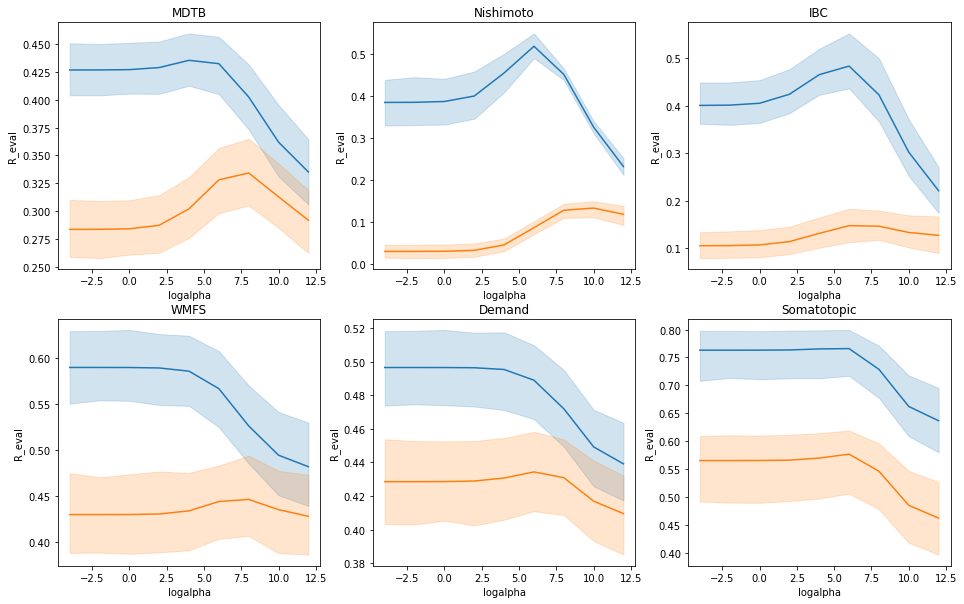

In [6]:
plt.figure(figsize=(16,10))
evd=['MDTB','Nishimoto','IBC','WMFS','Demand','Somatotopic']

for i,ed in enumerate(evd):
    ax=plt.subplot(2,3,i+1)
    d=dfall[(dfall.eval_dataset==ed) & (dfall.train_dataset==ed)]
    plt.title(ed)
    sns.lineplot(data=d,y='R_eval',x='logalpha',hue='model',legend=None)

In [7]:
df=dfall[(dfall.eval_dataset=='MDTB') & (dfall.train_dataset=='MDTB') & (dfall.logalpha==8)]
df.pivot_table(index=None,columns='model',values='R_eval',aggfunc='mean')

model,avg,loo
R_eval,0.40261,0.334225


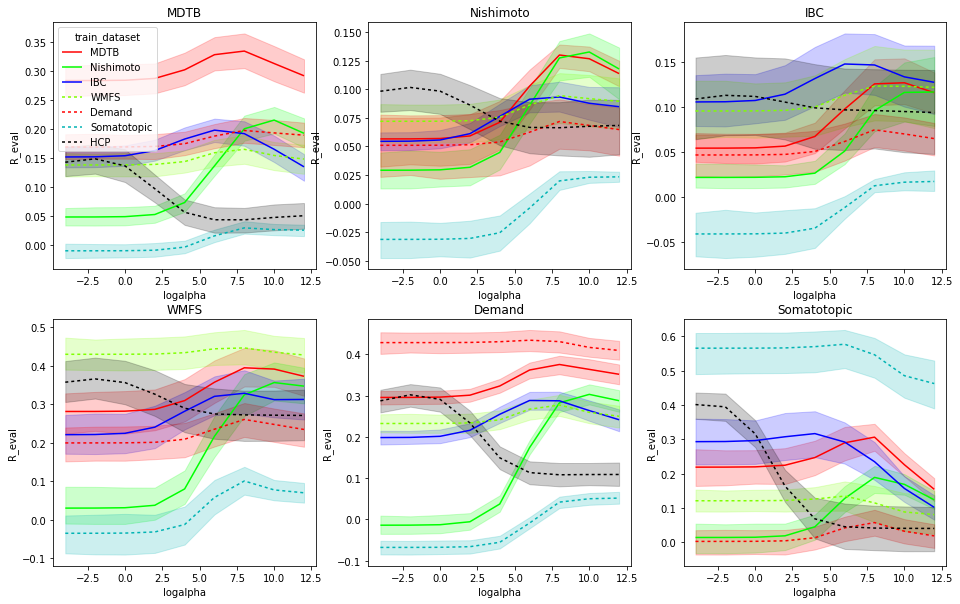

In [8]:
plt.figure(figsize=(16,10))
evd=['MDTB','Nishimoto','IBC','WMFS','Demand','Somatotopic']
ho = ['MDTB','Nishimoto','IBC','WMFS','Demand','Somatotopic','HCP']
palette = [[1,0,0],[0,1,0],[0,0,1],[0.5,1,0],[1,0,0],[0,0.7,0.7],[0,0,0]]
dashes = [[1,0],[1,0],[1,0],[2,2],[2,2],[2,2],[2,2]]

for i,ed in enumerate(evd):
    ax=plt.subplot(2,3,i+1)
    d=dfall[(dfall.eval_dataset==ed)
            & ((dfall.train_dataset!=ed)
            | (dfall.model=='loo'))]
    plt.title(ed)
    if i==0:
        sns.lineplot(data=d,y='R_eval',x='logalpha',hue='train_dataset',        palette=palette,style='train_dataset',
        hue_order=ho,style_order=ho,
        dashes=dashes)
    else:
        sns.lineplot(data=d,y='R_eval',x='logalpha',hue='train_dataset',palette=palette,style='train_dataset',
        hue_order=ho,style_order=ho,dashes=dashes,legend=None)


<AxesSubplot:xlabel='logalpha', ylabel='R_eval'>

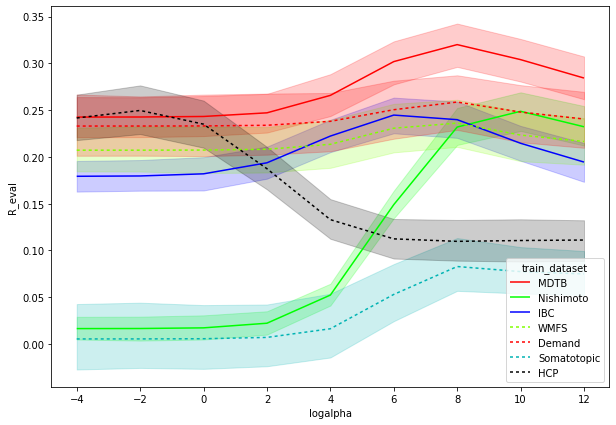

In [9]:
# Plot all evaluations on different datasets
plt.figure(figsize=(10,7))
d=dfall[(dfall.train_dataset!=dfall.eval_dataset) | (dfall.model=='loo')]
sns.lineplot(data=d,y='R_eval',x='logalpha',
             hue='train_dataset',style='train_dataset',
             hue_order=ho,style_order=ho,
             palette=palette,dashes=dashes)


In [10]:
# determine best logalpha for each model
pd.pivot_table(d,index=['train_dataset'],columns=['logalpha'],values=['R_eval'],aggfunc='mean')

R_eval                                                    \
logalpha          -4.0      -2.0       0.0       2.0       4.0       6.0    
train_dataset                                                               
Demand         0.232915  0.232929  0.233030  0.233747  0.237949  0.250385   
HCP            0.241534  0.249599  0.234926  0.187297  0.132824  0.112273   
IBC            0.179197  0.179531  0.181822  0.193620  0.222207  0.244656   
MDTB           0.242519  0.242597  0.243166  0.247052  0.265722  0.301846   
Nishimoto      0.016305  0.016399  0.017092  0.022045  0.052162  0.148874   
Somatotopic    0.005247  0.005273  0.005466  0.006865  0.016126  0.052841   
WMFS           0.207102  0.207118  0.207235  0.208077  0.213386  0.230596   

                                             
logalpha           8.0       10.0      12.0  
train_dataset                                
Demand         0.258599  0.247872  0.240413  
HCP            0.109592  0.110507  0.111018  
IBC            0.239738  0.214491  0.194391  
MDTB           0.320019  0.303951  0.284262  
Nishimoto      0.231855  0.248718  0.232156  
Somatotopic    0.082684  0.077236  0.074749  
WMFS           0.236069  0.223291  0.216425

In [11]:
A = pd.pivot_table(d,index=['train_dataset'],columns=['logalpha'],values=['R_eval'])
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a=np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
dfall['isbest'] = dfall.logalpha.values  == bestla.loc[dfall.train_dataset].values.flatten()

## Summary Graph of all evaluated at their best hyperparameter 

This is training each 

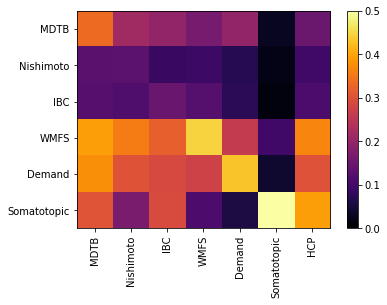

In [12]:
d=dfall[((dfall.train_dataset!=dfall.eval_dataset) | (dfall.model=='loo'))& dfall.isbest]


V=pd.pivot_table(d,index=['eval_dataset'],columns=['train_dataset'],values=['R_eval'])
A=pd.pivot_table(d,index=['eval_dataset'],columns=['train_dataset'],values=['noiseceiling_XY'])

V=V.iloc[[2,3,1,5,0,4],[3,4,2,6,0,5,1]]
A=A.iloc[[2,3,1,5,0,4],[3,4,2,6,0,5,1]]

plt.imshow(V.values,cmap='inferno',vmin=0,vmax=0.5)
ax=plt.gca()
ev_labels = V.index.values
tr_labels = A.columns.get_level_values(1).values
plt.xticks(np.arange(7),tr_labels)
ax.set_xticklabels(tr_labels, rotation = 90)
plt.yticks(np.arange(6),ev_labels)
plt.colorbar()
plt.savefig(fig_dir + '/connectivity_model_eval.pdf')

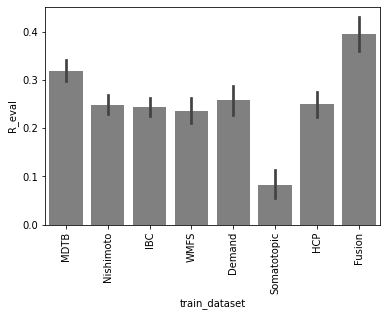

In [13]:
# Add the favorite Fusion model
dfuse = rm.comb_eval(models=['Fu06-loo'],eval_t = 'eval')
dall = pd.concat([d,dfuse],ignore_index=True)
ho = ['MDTB','Nishimoto','IBC','WMFS','Demand','Somatotopic','HCP','Fusion']
palette = [[1,0,0],[0,1,0],[0,0,1],[0.5,1,0],[1,0,0],[0,0.7,0.7],[0,0,0]]
sb.barplot(data=dall,x='train_dataset',y='R_eval',order=ho,color=[0.5,0.5,0.5])
ax=plt.gca()
a=ax.set_xticklabels(ho, rotation = 90)
plt.savefig(fig_dir + '/connectivity_model_fusion.pdf')

In [14]:
t=stats.ttest_rel(dall[dall['train_dataset']=='MDTB']['R_eval'],
                  dall[dall['train_dataset']=='Fusion']['R_eval'])
indx =dall['train_dataset']=='MDTB'
df=indx.sum()-1
print(f't({df}) = {t.statistic:.3f}, p={t.pvalue:.4e}')

t(102) = -7.340, p=5.3221e-11


In [15]:
# What predicition accuracy relative to noise-ceiling?

print(f"R_eval {dfuse.R_eval.mean():.4f} + {dfuse.R_eval.std():.2f}")
adj = dfuse.R_eval.mean() / dfuse.noiseceiling_XY.mean()
print(f"R_eval {adj:.4f} ")
print(f'Average noiseceiling{dfuse.noiseceiling_XY.mean():.4f} ')
print(f'variance predicted:{adj**2:.4f}')

R_eval 0.3959 + 0.17
R_eval 0.6840 
Average noiseceiling0.5788 
variance predicted:0.4679
